In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import parse_mnist

In [3]:
import context
import hier_clust
from collections import defaultdict, Counter

In [4]:
from impurity_utils import (
    construct_random_tree,
    convert_linkage_to_tree,
    random_leaf_impurity,
    avg_gini_impurity_tree,
    avg_gini_impurity_from_assignments,
    gini_impurity_single_node,
    add_counters_to_tree,
)

In [5]:
import scipy.cluster.hierarchy as sch

In [6]:
%%time

x_train = parse_mnist.parse_images("./train-images-idx3-ubyte.gz", add_constant = False)
y_train = parse_mnist.parse_labels("./train-labels-idx1-ubyte.gz")

x_test = parse_mnist.parse_images("./t10k-images-idx3-ubyte.gz", add_constant = False)
y_test = parse_mnist.parse_labels("./t10k-labels-idx1-ubyte.gz")

Parsing ./train-images-idx3-ubyte.gz as images
  numImages = 60000
  numRows = 28
  numCols = 28
  Done
Parsing ./train-labels-idx1-ubyte.gz as labels
  numItems = 60000
  Done
Parsing ./t10k-images-idx3-ubyte.gz as images
  numImages = 10000
  numRows = 28
  numCols = 28
  Done
Parsing ./t10k-labels-idx1-ubyte.gz as labels
  numItems = 10000
  Done
CPU times: user 5.61 s, sys: 734 ms, total: 6.34 s
Wall time: 6.38 s


In [7]:
n_obs = 1000
indices = np.arange(len(y_train))
np.random.seed(1)
np.random.shuffle(indices)
x = x_train[indices][:n_obs]
y = y_train[indices][:n_obs]
print(x.shape)
print(y.shape)

(1000, 784)
(1000,)


In [8]:
h_obj = hier_clust.HierClust()

In [9]:
%%time
np.random.seed(1)
tree, _ = h_obj.fit(x)

CPU times: user 4.92 s, sys: 165 ms, total: 5.08 s
Wall time: 5.16 s


In [10]:
trees = dict()
top_down_label = "Top Down"
trees[top_down_label] = tree

In [11]:
assignments_pruned = h_obj._get_assignments(tree.prune(depth=3))
avg_gini_impurity_from_assignments(assignments_pruned, labels=y)

0.5792004438428734

In [12]:
tree = add_counters_to_tree(tree, y)
#print tree.prune(3).str_display()
avg_gini_impurity_tree(tree.prune(3))

0.5792004438428733

In [13]:
import timeit
def create_timer():
    start = timeit.default_timer()
    def timer():
        return timeit.default_timer() - start
    return timer

In [14]:
#methods = ["single", "average", "complete", "ward"]
methods = ["average", "complete", "ward"]

for method in methods:
    timer = create_timer()
    print("Starting method: {}".format(method))
    try:
        link = sch.linkage(x, method=method)
    except Exception as e:
        print("Exception during clustering: {}".format(e))
    try:
        trees["BU ({})".format(method)] = convert_linkage_to_tree(link, labels = y)
    except Exception as e:
        print("Exception during post-processing: {}".format(e))
    print("Method '{}' elapsed time: {} seconds".format(method, timer()))

Starting method: average
Method 'average' elapsed time: 0.824178934097 seconds
Starting method: complete
Method 'complete' elapsed time: 0.729692935944 seconds
Starting method: ward
Method 'ward' elapsed time: 0.774585962296 seconds


In [15]:
%%time
np.random.seed(1)
random_tree = construct_random_tree(indices = np.arange(len(y)))
random_tree = add_counters_to_tree(random_tree, labels=y)
trees["Random 50% split"] = random_tree

CPU times: user 58.6 ms, sys: 4.2 ms, total: 62.8 ms
Wall time: 61.5 ms


BU (average)
BU (complete)
BU (ward)
Random 50% split
Top Down
CPU times: user 562 ms, sys: 40.7 ms, total: 603 ms
Wall time: 581 ms


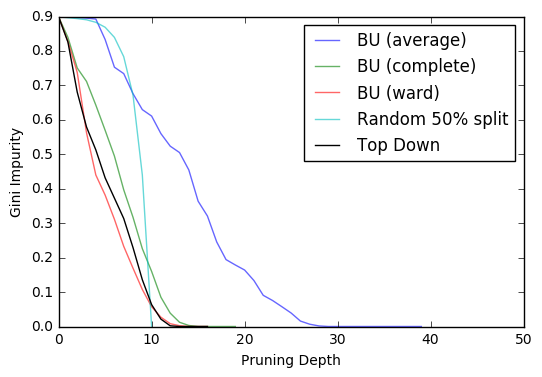

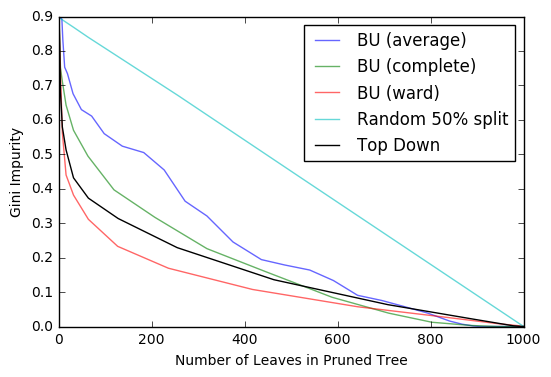

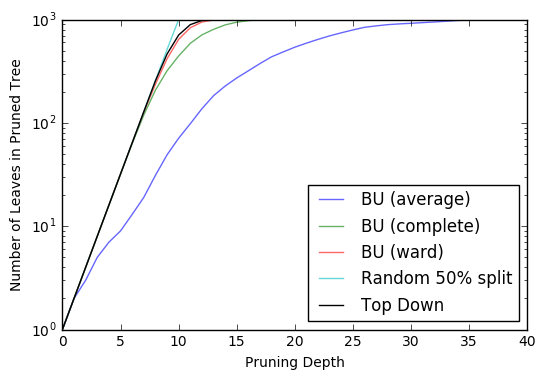

In [16]:
%%time

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

depths = np.arange(n_obs)
for name in sorted(trees.keys()):
    print(name)
    tree = trees[name]
    total_leaves = tree.num_leaves()
    list_num_leaves = []
    impurity = []
    depths_used = []
    for d in depths:
        pruned_tree = tree.prune(depth = d)
        impurity.append(avg_gini_impurity_tree(pruned_tree))
        num_leaves = pruned_tree.num_leaves()
        list_num_leaves.append(num_leaves)
        depths_used.append(d)
        if num_leaves == total_leaves:
            break
    if name == top_down_label:
        kw = dict(alpha=1.0, color='black')
    else:
        kw = dict(alpha = 0.6)
    ax1.plot(depths_used, impurity, label=name, **kw)
    ax2.plot(list_num_leaves, impurity, label=name, **kw)
    ax3.semilogy(depths_used, list_num_leaves, label=name, **kw)

ax1.legend(loc='best')
ax1.set_ylabel('Gini Impurity')
ax1.set_xlabel('Pruning Depth')
ax1.set_xlim(0, 50)

ax2.legend(loc='best')
ax2.set_ylabel('Gini Impurity')
ax2.set_xlabel('Number of Leaves in Pruned Tree')

ax3.legend(loc='best')
ax3.set_ylabel('Number of Leaves in Pruned Tree')
ax3.set_xlabel('Pruning Depth')

None

Note: Certain linkage methods (esp single and average) tend to produce lopsided trees

TODO: Need to make sure that `avg_gini_impurity` sensibly handles lopsided trees (instead of producing misleadingly low impurity).

Also, this highlights a drawback of the top-down hierarchical clustering approach: in contrast to bottom-up clustering, it does not support pruning to a target number of leaves.  To do so requires some notion of "distance" at each split (this distance metric serves as a tie-breaker when deciding which node to split next).  Consequently, the top-down approach only lets us prune to a target depth, not to a target number of leaves.

### Notes on results (3/2/17):

Top-down hierarchical clustering:
* 1000 observations - 5 sec
* 5000 observations - 55 sec
* 10000 observations - 145 sec
* 60000 observations - 1780 sec

Bottom-up hierarchical clustering ("average" linkage):
* 1000 observations - 1 sec
* 5000 observations - 50 sec
* 10000 observations - 360 sec
* 60000 observations - error (apparently due to an integer overflow)

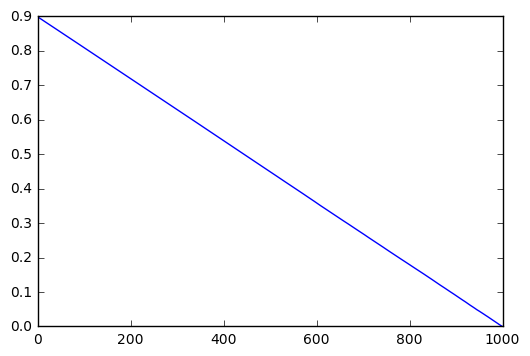

In [17]:
depths, impurity = random_leaf_impurity(y)
plt.plot(depths, impurity)
None